In [1]:
%run ../src/simulation.py

/Users/folgert/projects/coverage-based-standardization/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import pickle
import numpy as np

from copia.data import to_copia_dataset
import matplotlib.pyplot as plt

plt.style.use('default')

p = plt.rcParams
p["font.sans-serif"] = ["Atkinson Hyperlegible"]
p["font.weight"] = "light"

def expected_n(θ, C):
    return round(θ * C / (1 - C))

def estimate(p1, p2, θ1, θ2, C, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    n1 = expected_n(θ1, C)
    n2 = expected_n(θ2, C)

    s1 = to_copia_dataset(rng.choice(p1, size=n1, replace=False))
    s2 = to_copia_dataset(rng.choice(p2, size=n2, replace=False))
    datasets = s1, s2
    
    results = np.zeros((2, 3))
    for i, ds in enumerate(datasets):
        results[i, 0] = ds.n
        results[i, 1] = ds.S_obs
        results[i, 2] = compute_coverage(ds)
    return results

In [ ]:
import pandas as pd

def rarefaction_curve(ds, max_steps=None):
    if max_steps is None:
        max_steps = ds.n
    rarefaction = rarefaction_extrapolation(ds, max_steps=max_steps)
    coverage = estimate_coverage(ds, max_steps=max_steps)
    return rarefaction, coverage

def richness_at_coverage_argmin(rarefaction, coverage_curve, target_coverage):
    if np.max(coverage_curve) < target_coverage:
        return None
    idx = np.argmin(np.abs(coverage_curve - target_coverage))
    return rarefaction[idx]

def richness_at_coverage(ds, target_coverage, max_steps=None):
    rarefaction, cov_curve = rarefaction_curve(ds, max_steps=max_steps)    
    max_cov = np.max(cov_curve)
    
    if target_coverage > max_cov:
        return None
    
    idx = np.argmin(np.abs(cov_curve - target_coverage))
    return rarefaction[idx]

def estimate_pair(p1, p2, theta1, theta2, C_target, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    n1 = expected_n(theta1, C_target)
    n2 = expected_n(theta2, C_target)

    s1 = to_copia_dataset(rng.choice(p1, size=n1, replace=False))
    s2 = to_copia_dataset(rng.choice(p2, size=n2, replace=False))

    C1_hat = compute_coverage(s1)
    C2_hat = compute_coverage(s2)
    C_star = min(C1_hat, C2_hat)

    S1_star = richness_at_coverage(s1, C_star)
    S2_star = richness_at_coverage(s2, C_star)

    if S1_star is None or S2_star is None:
        return None

    return {
        "n1": n1,
        "n2": n2,
        "S1_obs": s1.S_obs,
        "S2_obs": s2.S_obs,
        "C1_hat": C1_hat,
        "C2_hat": C2_hat,
        "C_star": C_star,
        "S1_star": S1_star,
        "S2_star": S2_star,
    }


def simulate_comparisons_with_standardization(
    factor,
    C_targets=None,
    reps_per_pop=100,
    rng=None,
    populations_path="../data/threshold_populations1-{factor}.pkl"
):
    if rng is None:
        rng = np.random.default_rng()
    factor = int(factor) if factor >= 1 else factor

    with open(populations_path.format(factor=factor), "rb") as f:
        populations = pickle.load(f)

    N = 10**4
    mu1 = 1e-3
    mu2 = factor * mu1
    theta1 = 2 * N * mu1
    theta2 = 2 * N * mu2

    true_ratio = theta2 / theta1 

    if C_targets is None:
        C_targets = np.linspace(0.1, 0.8, 8)

    records = []

    for C_target in C_targets:
        for pop_id, (p1, p2) in enumerate(populations):
            for rep in range(reps_per_pop):
                est = estimate_pair(p1, p2, theta1, theta2, C_target, rng=rng)
                if est is None:
                    continue

                ratio_star = est["S2_star"] / est["S1_star"]
                records.append(dict(
                    factor=factor,
                    pop_id=pop_id,
                    C_target=C_target,
                    n1=est["n1"],
                    n2=est["n2"],
                    S1_obs=est["S1_obs"],
                    S2_obs=est["S2_obs"],
                    C1_hat=est["C1_hat"],
                    C2_hat=est["C2_hat"],
                    C_star=est["C_star"],
                    ratio_star=ratio_star,
                    true_ratio=true_ratio,
                ))

    return pd.DataFrame.from_records(records)

In [ ]:
def error_distribution_by_Cstar(
    df,
    bin_edges=None,
    group_by_factor=True,
    use_absolute_relative_error=True,
    quantiles=(0.1, 0.25, 0.5, 0.75, 0.9),
):

    if bin_edges is None:
        bin_edges = np.linspace(0.0, 1.0, 11)

    df = df.copy()

    rel_error = df["ratio_star"] / df["true_ratio"] - 1.0
    if use_absolute_relative_error:
        df["error"] = np.abs(rel_error)
    else:
        df["error"] = rel_error

    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df = df.dropna(subset=["error", "C_star"])

    df["C_bin"] = pd.cut(df["C_star"], bins=bin_edges, include_lowest=True)
    df["C_mid"] = df["C_bin"].apply(
        lambda x: 0.5 * (x.left + x.right) if pd.notnull(x) else np.nan
    )

    if group_by_factor and "factor" in df.columns:
        group_keys = ["factor", "C_bin", "C_mid"]
    else:
        group_keys = ["C_bin", "C_mid"]

    grouped = df.dropna(subset=["C_bin"]).groupby(group_keys, observed=False)

    records = []
    for key, sub in grouped:
        errs = sub["error"].to_numpy()
        errs = errs[np.isfinite(errs)]
        n = len(errs)
        if n == 0:
            continue

        rec = {}
        if group_by_factor and "factor" in df.columns:
            factor, C_bin, C_mid = key
            rec["factor"] = factor
        else:
            C_bin, C_mid = key
            rec["factor"] = None

        rec["C_bin"] = C_bin
        rec["C_mid"] = C_mid
        rec["n"] = n
        rec["mean_error"] = errs.mean()
        rec["std_error"] = errs.std(ddof=1) if n > 1 else 0.0
        rec["rms_error"] = np.sqrt((errs ** 2).mean())

        q_vals = np.quantile(errs, quantiles)
        for q, v in zip(quantiles, q_vals):
            rec[f"err_q{q:.2f}"] = v

        records.append(rec)

    summary_df = pd.DataFrame.from_records(records)
    return summary_df

In [8]:
import matplotlib.pyplot as plt

def plot_error_by_Cstar(summary_df, stat_col="err_q0.50", ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    for factor, sub in summary_df.groupby("factor"):
        ax.plot(sub["C_mid"], sub[stat_col], marker="o", 
                markerfacecolor="none", label=rf"$\mu_2 / \mu_1$={factor}")
    ax.legend(frameon=False)

    ax.set_xlabel(r"Shared comparison coverage $C^{\star}$ (binned)")
    ax.set_ylabel(f"{stat_col} of error")
    ax.set_title("Error distribution across coverage bins")
    ax.grid(alpha=0.3)

    return ax

In [9]:
all_df = []

rng = np.random.default_rng()
for factor in (2, 3, 4):
    df = simulate_comparisons_with_standardization(
        factor=factor,
        C_targets=np.linspace(0.1, 0.8, 8),
        reps_per_pop=100,
        rng=rng
    )
    all_df.append(df)

all_df = pd.concat(all_df, ignore_index=True)

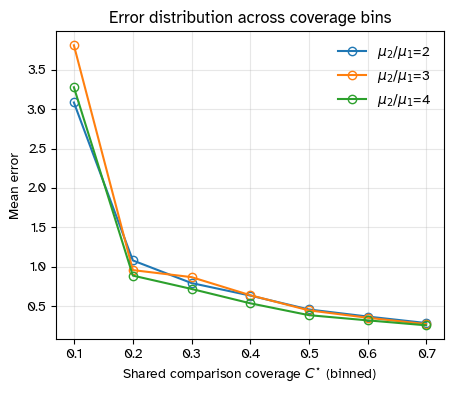

In [10]:
summary_df = error_distribution_by_Cstar(
    all_df, bin_edges=np.linspace(0.05, 0.75, 8), use_absolute_relative_error=True)

fig, ax = plt.subplots(figsize=(5, 4))
plot_error_by_Cstar(summary_df, stat_col="mean_error", ax=ax)
ax.set_ylabel("Mean error");
fig.savefig("../images/elbow-error.png", dpi=300, bbox_inches="tight")

In [ ]:
import numpy as np
import pandas as pd

def error_distribution_by_nstar(
    df,
    bin_edges=None,
    group_by_factor=True,
    use_absolute_relative_error=True,
    quantiles=(0.10, 0.25, 0.50, 0.75, 0.90),
):
    df = df.copy()

    true_ratio = df["true_ratio"].values
    hat_ratio = df["ratio_star"].values
    
    rel_error = hat_ratio / true_ratio - 1.0
    error = np.abs(rel_error) if use_absolute_relative_error else rel_error
    df["error"] = error
    df["n_star"] = df[["n1", "n2"]].min(axis=1)

    if bin_edges is None:
        min_n = 10 #df["n_star"].min()
        max_n = df["n_star"].max()
        bin_edges = np.linspace(min_n, max_n, 15)

    df["n_bin"] = pd.cut(df["n_star"], bins=bin_edges, include_lowest=True)
    df["n_mid"] = df["n_bin"].apply(lambda x: x.left if pd.notnull(x) else np.nan)


    if group_by_factor and "factor" in df.columns:
        group_keys = ["factor", "n_bin", "n_mid"]
    else:
        group_keys = ["n_bin", "n_mid"]

    grouped = df.dropna(subset=["n_bin"]).groupby(group_keys)

    records = []

    for key, sub in grouped:
        errs = sub["error"].values
        n = len(errs)

        rec = {}

        if group_by_factor and "factor" in df.columns:
            factor, n_bin, n_mid = key
            rec["factor"] = factor
        else:
            n_bin, n_mid = key
            rec["factor"] = None

        rec["n_bin"] = n_bin
        rec["n_mid"] = n_mid
        rec["n"] = n

        rec["mean_error"] = errs.mean()
        rec["std_error"] = errs.std(ddof=1) if n > 1 else 0.0
        rec["rms_error"] = np.sqrt((errs ** 2).mean())

        q_vals = np.quantile(errs, quantiles)
        for q, v in zip(quantiles, q_vals):
            rec[f"err_q{q:.2f}"] = v

        records.append(rec)

    summary_df = pd.DataFrame.from_records(records)
    return summary_df


In [12]:
error_distribution_by_nstar(all_df, use_absolute_relative_error=True, bin_edges=None)

/var/folders/sn/66dvqdn12v9dgr0vrs566dp00000gn/T/ipykernel_88199/2997768506.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.dropna(subset=["n_bin"]).groupby(group_keys)


,factor,n_bin,n_mid,n,mean_error,std_error,rms_error,err_q0.10,err_q0.25,err_q0.50,err_q0.75,err_q0.90
0,2,"(9.999, 15.0]",9.999,9716,0.845974,1.224430,1.488203,0.112613,0.260789,0.500000,0.843678,1.966334
1,2,"(15.0, 20.0]",15.000,10000,0.572332,0.712755,0.914075,0.070423,0.190201,0.399157,0.669933,1.190895
2,2,"(25.0, 30.0]",25.000,9997,0.426245,0.438252,0.611335,0.054407,0.149773,0.315639,0.535567,0.910718
3,2,"(45.0, 50.0]",45.000,9949,0.327360,0.319952,0.457738,0.045481,0.115591,0.246314,0.431898,0.678055
4,2,"(75.0, 80.0]",75.000,10000,0.253620,0.228751,0.341533,0.037745,0.093578,0.197926,0.341262,0.528837
5,3,"(9.999, 15.0]",9.999,9959,0.756028,1.032156,1.279381,0.093093,0.235590,0.503045,0.794305,1.597138
6,3,"(15.0, 20.0]",15.000,9994,0.542894,0.641433,0.840315,0.066667,0.187500,0.387987,0.650255,1.114175
7,3,"(25.0, 30.0]",25.000,10000,0.399742,0.398598,0.564498,0.053561,0.142304,0.306927,0.518928,0.805585
8,3,"(45.0, 50.0]",45.000,9993,0.304217,0.283152,0.415590,0.043326,0.109442,0.236287,0.408452,0.628483
9,3,"(75.0, 80.0]",75.000,9998,0.233741,0.206746,0.312049,0.033112,0.085068,0.183510,0.319568,0.485990


/var/folders/sn/66dvqdn12v9dgr0vrs566dp00000gn/T/ipykernel_88199/2997768506.py:36: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.dropna(subset=["n_bin"]).groupby(group_keys)


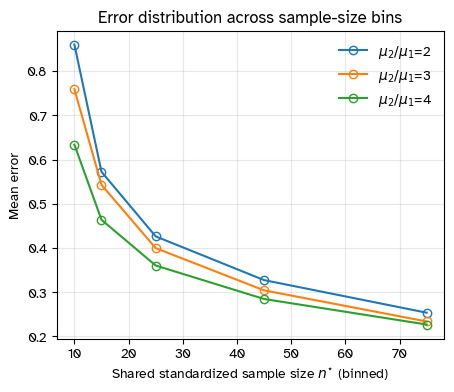

In [13]:
def plot_error_by_nstar(summary_df, stat_col="err_q0.50", ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    for factor, sub in summary_df.groupby("factor"):
        sub = sub.sort_values("n_mid")
        ax.plot(
            sub["n_mid"],
            sub[stat_col],
            marker="o",
            markerfacecolor="none",
            label=rf"$\mu_2 / \mu_1$={factor}"
        )

    ax.legend(frameon=False)
    ax.set_xlabel(r"Shared standardized sample size $n^{\star}$ (binned)")
    ax.set_ylabel(f"{stat_col} of error")
    ax.set_title("Error distribution across sample-size bins")
    ax.grid(alpha=0.3)
    return ax

fig, ax = plt.subplots(figsize=(5, 4))
summary_df = error_distribution_by_nstar(all_df[all_df["C_star"] > 0], use_absolute_relative_error=True, bin_edges=None)
plot_error_by_nstar(summary_df, stat_col="mean_error", ax=ax)
ax.set_ylabel("Mean error")
fig.savefig("../images/elbow-error-n.png", dpi=300, bbox_inches="tight")